In [1]:
# Install TensorFlow
!pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Install OpenCV to resolve the missing module error
!pip install opencv-python-headless


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [13]:

# Then we can keep the original imports
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import os
from skimage.measure import label
import tifffile as tiff

import matplotlib.pyplot as plt
import random

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from scipy.ndimage import binary_fill_holes
# Force CPU: disable GPU visibility





In [16]:
import zipfile

# Path to your zip file in the Google Drive integration
file_path = './monuseg_test/MoNuSegTestData (2).zip'

try:
    # First, we need to extract the contents of the zip file
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        # List the contents of the zip file
        print("Contents of zip file:")
        print(zip_ref.namelist())
        
        # Extract all contents to a directory
        zip_ref.extractall('/tmp/monuseg_extracted')
        
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please check if the file exists and the path is correct.")
except zipfile.BadZipFile:
    print(f"Error: {file_path} is not a valid zip file.")

Contents of zip file:
['MoNuSegTestData/', 'MoNuSegTestData/TCGA-2Z-A9J9-01A-01-TS1.tif', 'MoNuSegTestData/TCGA-2Z-A9J9-01A-01-TS1.xml', 'MoNuSegTestData/TCGA-44-2665-01B-06-BS6.tif', 'MoNuSegTestData/TCGA-44-2665-01B-06-BS6.xml', 'MoNuSegTestData/TCGA-69-7764-01A-01-TS1.tif', 'MoNuSegTestData/TCGA-69-7764-01A-01-TS1.xml', 'MoNuSegTestData/TCGA-A6-6782-01A-01-BS1.tif', 'MoNuSegTestData/TCGA-A6-6782-01A-01-BS1.xml', 'MoNuSegTestData/TCGA-AC-A2FO-01A-01-TS1.tif', 'MoNuSegTestData/TCGA-AC-A2FO-01A-01-TS1.xml', 'MoNuSegTestData/TCGA-AO-A0J2-01A-01-BSA.tif', 'MoNuSegTestData/TCGA-AO-A0J2-01A-01-BSA.xml', 'MoNuSegTestData/TCGA-CU-A0YN-01A-02-BSB.tif', 'MoNuSegTestData/TCGA-CU-A0YN-01A-02-BSB.xml', 'MoNuSegTestData/TCGA-EJ-A46H-01A-03-TSC.tif', 'MoNuSegTestData/TCGA-EJ-A46H-01A-03-TSC.xml', 'MoNuSegTestData/TCGA-FG-A4MU-01B-01-TS1.tif', 'MoNuSegTestData/TCGA-FG-A4MU-01B-01-TS1.xml', 'MoNuSegTestData/TCGA-GL-6846-01A-01-BS1.tif', 'MoNuSegTestData/TCGA-GL-6846-01A-01-BS1.xml', 'MoNuSegTestData/

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease




libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
X shape: (14, 1000, 1000, 3)
Y shape: (14, 1000, 1000)


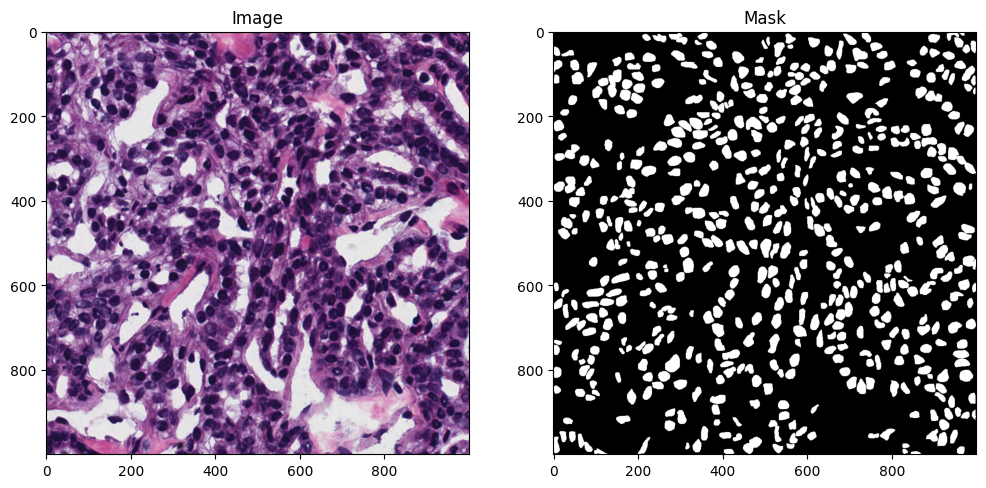

In [19]:
# First, let's install the required OpenGL library
!apt-get update && apt-get install -y libgl1-mesa-glx

# Now we can run the original code
import numpy as np
from pathlib import Path
import tifffile
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt

def xml_to_mask(xml_path, image_shape):
    # Parse XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Create empty mask
    mask = Image.new('L', (image_shape[1], image_shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    
    # Extract and draw all nuclei polygons
    for region in root.findall('.//Region'):
        vertices = region.find('Vertices')
        points = []
        for vertex in vertices.findall('Vertex'):
            x = float(vertex.get('X'))
            y = float(vertex.get('Y'))
            points.append((x, y))
        draw.polygon(points, fill=255)
    
    return np.array(mask)

# Get paths for all images and masks
base_path = Path('/tmp/monuseg_extracted/MoNuSegTestData')  # Updated path to match extraction location
image_paths = sorted(base_path.glob('*.tif'))
mask_paths = sorted(base_path.glob('*.xml'))

# Create X and Y arrays
X = []
Y = []

for img_path, xml_path in zip(image_paths, mask_paths):
    # Read image
    img = tifffile.imread(str(img_path))
    
    # Create mask from XML
    mask = xml_to_mask(xml_path, img.shape)
    
    # Append to lists
    X.append(img)
    Y.append(mask)

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)
masks_true = Y

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

# Optional: Display first image and mask
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X[0])
plt.title('Image')
plt.subplot(122)
plt.imshow(Y[0], cmap='gray')
plt.title('Mask')
plt.show()

In [22]:
!pip install torchvision


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import os
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
# Force CPU if CUDA is not working



# === CONFIGURATION ===
folder_path = './cw_stardist/'  # Path to folder with .tif images
model_name = "2D_versatile_he"  # Pretrained StarDist model

# === STEP 1: Load images as tensors ===
print("Loading .tif images...")
tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.tif')]

transform = transforms.Compose([
    transforms.ToTensor()  # Converts [H, W, C] in [0,255] to [C, H, W] in [0,1]
])

img_list = []
file_names = []

for tif_file in tqdm(tif_files, desc="Loading images"):
    img_path = os.path.join(folder_path, tif_file)
    img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
    img_tensor = transform(img)
    img_list.append(img_tensor)
    file_names.append(tif_file)


Loading .tif images...
Loading images: 100%|██████████| 14/14 [00:01<00:00, 12.04it/s]


In [28]:
# === STEP 2: Normalize for StarDist ===
print("Normalizing images for StarDist input...")
X_norm = []
for x in tqdm(img_list, desc="Normalizing"):
    x_np = x.permute(1, 2, 0).numpy()  # [H, W, C]
    x_norm = normalize(x_np, 1, 99.8, axis=(0, 1))
    X_norm.append(x_norm)

# === STEP 3: Load StarDist model ===
print(f"Loading StarDist model: {model_name}")
model = StarDist2D.from_pretrained(model_name)

# === STEP 4: Predict masks ===
Y_pred = []
valid_indices = []

print("Running StarDist predictions...")
for i, img in tqdm(enumerate(X_norm), total=len(X_norm), desc="Predicting masks"):
    try:
        pred_mask, _ = model.predict_instances(
            img,
            n_tiles=model._guess_n_tiles(img),
            show_tile_progress=False
        )
        Y_pred.append(pred_mask)
        valid_indices.append(i)
    except Exception as e:
        print(f"[Error] Image '{file_names[i]}' failed: {e}")

print(f"\n✅ Done! Successfully processed {len(valid_indices)} / {len(img_list)} images.")

Normalizing images for StarDist input...
Normalizing: 100%|██████████| 14/14 [00:00<00:00, 17.62it/s]
2025-06-14 06:28:12.798691: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-14 06:28:12.798731: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-06-14 06:28:12.798739: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-06-14 06:28:12.798745: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-06-14 06:28:12.798751: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic informa

In [34]:
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
import os

pred_mask = Y_pred

# Functions
def get_object_count(mask):
    return len(np.unique(mask)) - 1  # subtract background (label 0)

def get_total_area(mask):
    return np.sum(mask > 0)

# Example: if you already have masks_pred
cell_counts = [get_object_count(mask) for mask in pred_mask]
cell_areas = [get_total_area(mask) for mask in pred_mask]

# Optional: if you have image filenames or IDs
image_names = [f"image_{i}" for i in range(len(pred_mask))]  # or use actual filenames

# Create DataFrame
df_stats = pd.DataFrame({
    "image_name": image_names,
    "object_count": cell_counts,
    "total_area": cell_areas
})

# Save to CSV
df_stats.to_csv("/work/stardist_cw_histaugan_segmentation_stats.csv", index=False)
print("✅ Stats saved to /work/histaugan_segmentation_stats.csv")


✅ Stats saved to /work/histaugan_segmentation_stats.csv


In [67]:
from stardist.matching import matching_dataset
from tqdm import tqdm
import pandas as pd
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats_per_tau = {}

stats_list = []
# Convert GT to instance masks
Y_labeled = [label((m == 255).astype(np.uint16)) for m in Y]

for t in tqdm(taus, desc="Computing matching stats"):
    stats = matching_dataset(
        y_true=Y_labeled,
        y_pred=Y_pred ,  
        thresh=t,
        show_progress=False
    )
    print(f"Tau={t:.2f}: {stats}")
    stats_per_tau[t] = stats

    stats_dict = stats.to_dict()
    stats_dict["threshold"] = t  # optional, if not already included
    stats_list.append(stats_dict)

# Create DataFrame
df_stats = pd.DataFrame(stats_list)

# Save to CSV with original column names
df_stats.to_csv("stardist_CW.csv", index=False)
print("Saved evaluation stats to 'stardist_eval_raw_stats.csv'")

Computing matching stats: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]Tau=0.90: DatasetMatching(criterion='iou', thresh=0.9, fp=6803, tp=115, fn=5888, precision=0.01662330153223475, recall=0.019157088122605363, accuracy=0.008980165547399657, f1=0.01780047983902175, n_true=6003, n_pred=6918, mean_true_score=0.017491648619361228, mean_matched_score=0.9130640579306561, panoptic_quality=0.016252978354930028, by_image=False)
Saved evaluation stats to 'stardist_eval_raw_stats.csv'



In [37]:
# === CONFIGURATION ===
folder_path_umcu = './umcu/'  # Path to folder with .tif images
model_name_umcu = "2D_versatile_he"  # Pretrained StarDist model

# === STEP 1: Load images as tensors ===
print("Loading .tif images...")
tif_files_umcu = [f for f in os.listdir(folder_path_umcu) if f.lower().endswith('.tif')]

transform = transforms.Compose([
    transforms.ToTensor()  # Converts [H, W, C] in [0,255] to [C, H, W] in [0,1]
])

img_list_umcu = []
file_names_umcu = []

for tif_file in tqdm(tif_files_umcu, desc="Loading images"):
    img_path_umcu = os.path.join(folder_path, tif_file)
    img_umcu = Image.open(img_path_umcu).convert('RGB')  # Ensure 3 channels
    img_tensor_umcu = transform(img_umcu)
    img_list_umcu.append(img_tensor_umcu)
    file_names_umcu.append(tif_file)

Loading .tif images...
Loading images: 100%|██████████| 14/14 [00:02<00:00,  5.29it/s]


In [40]:
# === STEP 2: Normalize H&E RGB images ===
print("Normalizing images for StarDist input...")
X_norm_umcu = []
for x in tqdm(img_list_umcu, desc="Normalizing"):
    x_np = x.permute(1, 2, 0).numpy()  # Convert [C, H, W] → [H, W, C]
    x_norm_umcu = normalize(x_np, 1, 99.8, axis=(0, 1))  # Normalize per image
    X_norm_umcu.append(x_norm_umcu)  # Append the normalized image to the list

# === STEP 3: Load StarDist model ===
print(f"Loading StarDist model: {model_name_umcu}")
model = StarDist2D.from_pretrained(model_name_umcu)

# === STEP 4: Predict masks ===
Y_pred_umcu = []
valid_indices_umcu = []

print("Running StarDist predictions...")
for i, img in tqdm(enumerate(X_norm_umcu), total=len(X_norm_umcu), desc="Predicting masks"):
    try:
        pred_mask, _ = model.predict_instances(
            img,
            n_tiles=model._guess_n_tiles(img),
            show_tile_progress=False
        )
        Y_pred_umcu.append(pred_mask)
        valid_indices_umcu.append(i)
    except Exception as e:
        print(f"[Error] Image '{file_names_umcu[i]}' failed: {e}")

print(f"\nDone! Successfully processed {len(valid_indices_umcu)} / {len(img_list_umcu)} images.")

Normalizing images for StarDist input...
Normalizing: 100%|██████████| 14/14 [00:00<00:00, 17.00it/s]
Loading StarDist model: 2D_versatile_he
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Running StarDist predictions...
Predicting masks: 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]
Done! Successfully processed 14 / 14 images.



In [43]:
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
import os

pred_mask = Y_pred

# Functions
def get_object_count(mask):
    return len(np.unique(mask)) - 1  # subtract background (label 0)

def get_total_area(mask):
    return np.sum(mask > 0)

# Example: if you already have masks_pred
cell_counts = [get_object_count(mask) for mask in Y_pred_umcu]
cell_areas = [get_total_area(mask) for mask in Y_pred_umcu]

# Optional: if you have image filenames or IDs
image_names = [f"image_{i}" for i in range(len(Y_pred_umcu))]  # or use actual filenames

# Create DataFrame
df_stats = pd.DataFrame({
    "image_name": image_names,
    "object_count": cell_counts,
    "total_area": cell_areas
})

# Save to CSV
df_stats.to_csv("/work/stardist_UMCU_histaugan_segmentation_stats.csv", index=False)
print("✅ Stats saved to /work/histaugan_segmentation_stats.csv")


✅ Stats saved to /work/histaugan_segmentation_stats.csv


In [106]:
from stardist.matching import matching_dataset
from tqdm import tqdm
import pandas as pd
from skimage.measure import label

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats_list_umcu = []

# Convert GT to instance masks
Y_labeled_umcu = [label((m == 255).astype(np.uint16)) for m in Y]

for t in tqdm(taus, desc="Computing matching stats"):
    stats = matching_dataset(
        y_true=Y_labeled_umcu,
        y_pred=Y_pred_umcu,  
        thresh=t,
        show_progress=False
    )
    print(f"Tau={t:.2f}: {stats}")
    stats_per_tau[t] = stats
    
    # Manually extract attributes from the stats object
    stats_dict = {
        "criterion": stats.criterion,
        "thresh": stats.thresh,
        "fp": stats.fp,
        "tp": stats.tp,
        "fn": stats.fn,
        "precision": stats.precision,
        "recall": stats.recall,
        "accuracy": stats.accuracy,
        "f1": stats.f1,
        "n_true": stats.n_true,
        "n_pred": stats.n_pred,
        "mean_true_score": stats.mean_true_score,
        "mean_matched_score": stats.mean_matched_score,
        "panoptic_quality": stats.panoptic_quality,
        "by_image": stats.by_image,
        "threshold": t
    }
    stats_list_umcu.append(stats_dict)

# Create DataFrame
df_stats_umcu = pd.DataFrame(stats_list_umcu)

# Save to CSV
df_stats_umcu.to_csv("stardist_umcu.csv", index=False)
print("Saved evaluation stats to 'stardist_umcu.csv'")

Computing matching stats: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]Tau=0.90: DatasetMatching(criterion='iou', thresh=0.9, fp=6803, tp=115, fn=5888, precision=0.01662330153223475, recall=0.019157088122605363, accuracy=0.008980165547399657, f1=0.01780047983902175, n_true=6003, n_pred=6918, mean_true_score=0.017491648619361228, mean_matched_score=0.9130640579306561, panoptic_quality=0.016252978354930028, by_image=False)
Saved evaluation stats to 'stardist_umcu.csv'

